# ***Machine Learning Project***

## **Part1** - Implementation of ARIMA model 

In [25]:
# General
import json
import warnings
import time
import os
import copy
import pickle
import random
#import utils
from datetime import datetime
from datetime import timedelta
import dateutil.parser

# Data Collection and Processing
from pandas_datareader import DataReader
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook, tnrange

# Statistics and Modelling
import statsmodels.api as sm
from scipy.stats import kurtosis
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import talib
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Config
%matplotlib inline
%config InlineBackend.figure_format='retina'
warnings.filterwarnings("ignore")

## 1. Download - Stock - 20 years - Daily : Open, Close, High , Low , Volume

In [26]:
import yfinance as yf
TICKER = 'MSFT'

df = pd.read_csv(f'{TICKER}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.tail(10)
ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV')
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m%d')
all_df = pd.merge(df[['Date', 'Close', 'Volume']], ff, on='Date', how='left')
all_df = all_df.dropna()
all_df['Return'] = all_df['Close']/all_df['Close'].shift(1) - 1
all_df.dropna(inplace=True)
all_df.head()

,Date,Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,Return
1,1986-03-14,0.063809,308160000,1.03,-0.83,-0.22,0.12,0.30,0.03,0.035713
2,1986-03-17,0.064909,133171200,-0.75,0.00,-0.32,0.39,0.03,0.03,0.017249
3,1986-03-18,0.063258,67766400,0.47,0.04,-0.17,-0.08,0.28,0.03,-0.025431
4,1986-03-19,0.062158,47894400,-0.17,0.15,-0.09,0.14,0.23,0.03,-0.017391
5,1986-03-20,0.060508,58435200,0.39,-0.13,-0.02,0.12,0.12,0.03,-0.026547


###  Earnings  Data Downlaod  

In [27]:
earnings_df = pd.read_csv(f'earnings_{TICKER}.csv')

# Convert Date column to datetime
earnings_df['Date'] = pd.to_datetime(earnings_df['report_date'])

edf = earnings_df[['Date']]
edf['earnings'] = 1

all_df = pd.merge(all_df, edf, on='Date', how='left')
all_df = all_df.fillna(0)

print(f'There are {all_df.earnings.sum()} earning dates released')
all_df = all_df.set_index('Date', drop=True)

There are 95.0 earning dates released


## 2. Function to generate list of Technical Indicators 

In [28]:
def get_technical_indicators(dataset):

    # Create 7 and 21 days Moving Average
    dataset["sma_21"] = talib.SMA(dataset["Close"],7)
    #dataset["sma_7"] = talib.SMA(df_["Close"],7)
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    #dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Momentum
    dataset['momentum'] = talib.MOM(dataset['Close'], timeperiod=10)
      
    return dataset

all_df = get_technical_indicators(all_df).dropna()
all_df = all_df[all_df["Return"]!=0.000]

## 3. Data lag 

In [29]:
minLagNum = 1

maxLagNum = 3 
dataForMl = all_df

dataForMl["momentumLag_1"] = dataForMl["momentum"].shift(1)
dataForMl["momentumLag_3"] = dataForMl["momentum"].shift(3)
dataForMl["MACDLag_2"]     = dataForMl["MACD"].shift(2)

all_df = dataForMl.dropna()
all_df[['Mkt-RF','RF','SMB','HML','26ema','momentumLag_1','upper_band','momentumLag_3','sma_21','MACDLag_2']]

,Mkt-RF,RF,SMB,HML,26ema,momentumLag_1,upper_band,momentumLag_3,sma_21,MACDLag_2
Date,,,,,,,,,,
1986-04-17,0.33,0.024,0.31,-0.27,0.062336,0.005501,0.066075,0.002200,0.063887,0.000369
1986-04-18,-0.11,0.024,0.44,-0.11,0.062512,0.005501,0.066437,0.003300,0.064280,0.000708
1986-04-22,-0.78,0.024,0.73,0.10,0.062720,0.003301,0.066532,0.005501,0.064595,0.000916
1986-04-23,-0.42,0.024,0.03,0.03,0.062788,0.002750,0.066454,0.005501,0.064555,0.000913
1986-04-24,0.18,0.024,0.28,-0.51,0.063375,0.001925,0.067988,0.003301,0.065420,0.000802
...,...,...,...,...,...,...,...,...,...,...
2021-02-22,-1.12,0.000,0.68,3.14,235.183272,-0.482773,248.672340,5.228302,241.580059,5.862784
2021-02-23,-0.15,0.000,-1.05,0.90,235.001741,-7.117020,248.082531,1.345261,240.060968,5.403175
2021-02-24,1.15,0.000,1.48,1.34,234.928254,-8.622925,247.788036,-0.482773,238.653214,4.467367



## 4. Breaking data into train and test along time dim

In [30]:
test_percent = 0.10
no_test_obs =  int(np.round(test_percent*len(all_df)))
training = all_df[:-no_test_obs]
testing = all_df[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.05
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]

from sklearn.preprocessing import MinMaxScaler
trainMinmax = training.dropna(axis =0)
valMinmax = validation.dropna(axis =0)
outSampleMinmax = outOfSample.dropna(axis =0)

trainMinmax = pd.DataFrame(trainMinmax, columns = all_df.columns, index = training.index).dropna()
valMinmax = pd.DataFrame(valMinmax, columns = all_df.columns, index =validation.index).dropna()
outSampleMinmax = pd.DataFrame(outSampleMinmax, columns = all_df.columns, index = outOfSample.index).dropna()

## 5. Predection Using ARIMA

### Function to test stationary 

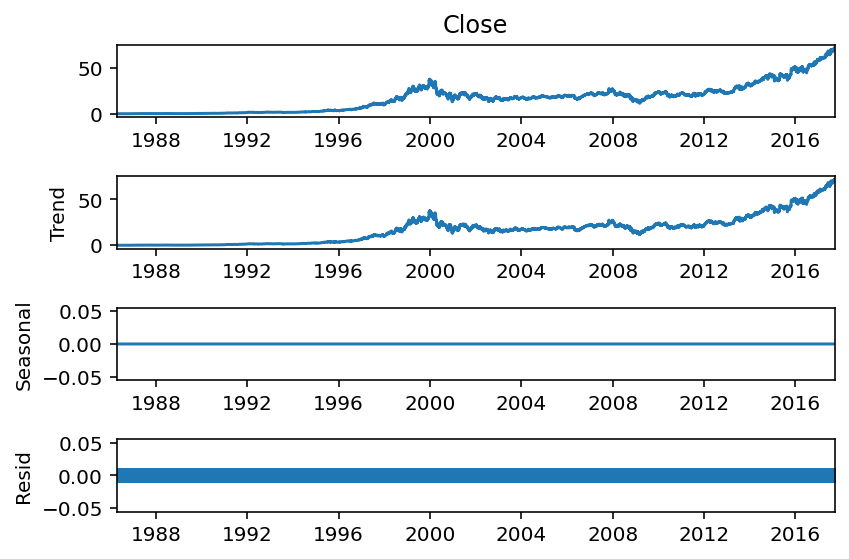

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
def test_stationarity(df, ts):
    # Determing rolling statistics

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], autolag='AIC')  # add kpss
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    

    if (dfoutput[0] < 0.05) :
        print("\nTime Series Stationary as P value ( {} ) < 0.05".format(round(dftest[1],5)))
    else:
        print("\nTime Series is not Stationary as P value ( {} ) > 0.05".format(round(dftest[1],5)))

    return dfoutput

result = seasonal_decompose(trainMinmax["Close"], model='additive', freq=1)
result.plot()
plt.show()

In [32]:
print(test_stationarity(trainMinmax,"Close"))
print(test_stationarity(trainMinmax,"Return"))

Results of Dickey-Fuller Test:

Time Series is not Stationary as P value ( 0.99897 ) > 0.05
Test Statistic                    2.327120
p-value                           0.998972
# Lags Used                      36.000000
Number of Observations Used    7686.000000
Critical Value (1%)              -3.431201
Critical Value (5%)              -2.861916
Critical Value (10%)             -2.566970
dtype: float64
Results of Dickey-Fuller Test:

Time Series Stationary as P value ( 0.0 ) < 0.05
Test Statistic                  -47.044395
p-value                           0.000000
# Lags Used                       3.000000
Number of Observations Used    7719.000000
Critical Value (1%)              -3.431197
Critical Value (5%)              -2.861915
Critical Value (10%)             -2.566969
dtype: float64


### Autocorrelation and Partial Autocorrelation

the time series reaches stationarity with two orders of differencing


<Figure size 1080x840 with 0 Axes>

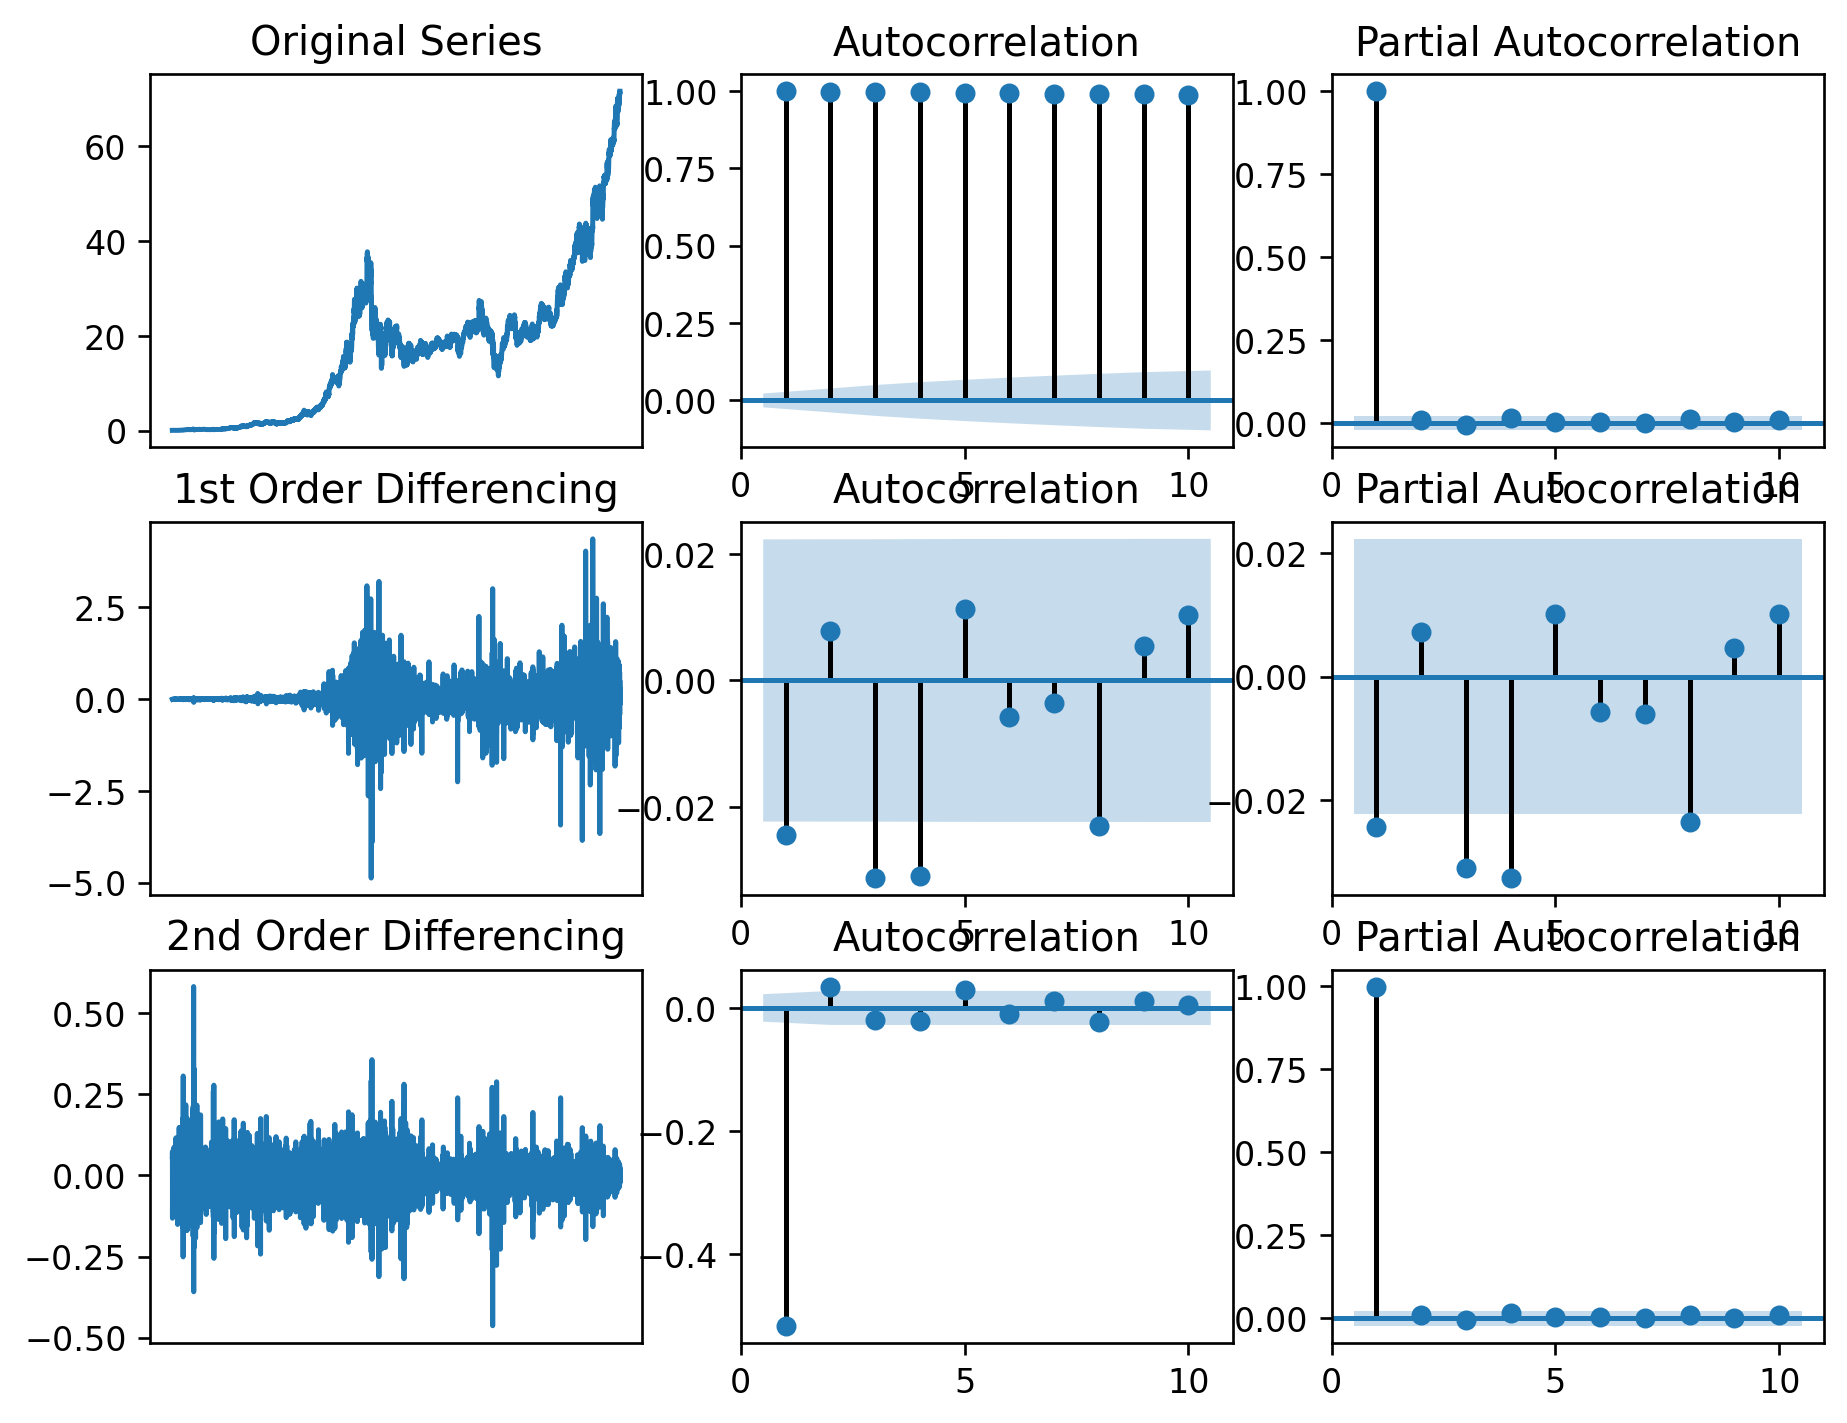

In [33]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.subplots_adjust(top = 1, bottom=0.1, hspace=1.5, wspace=0.4)
# Import data

print ( "the time series reaches stationarity with two orders of differencing")

# Original Series
fig, axes = plt.subplots(3, 3, sharex=False)
axes[0, 0].axes.xaxis.set_visible(False)
axes[0, 0].plot(trainMinmax["Close"])
axes[0, 0].set_title('Original Series')
plot_acf(trainMinmax["Close"], ax=axes[0, 1],lags=10, zero=False)
plot_pacf(trainMinmax["Close"], ax=axes[0, 2],lags=10, zero=False)


# 1st Differencing
axes[1, 0].axes.xaxis.set_visible(False)
axes[1, 0].plot(trainMinmax["Close"].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(trainMinmax.Close.diff().dropna(), ax=axes[1, 1],lags=10, zero=False)
plot_pacf(trainMinmax.Close.diff().dropna(),ax=axes[1, 2],lags=10, zero=False)

# 2nd Differencing
axes[2, 0].axes.xaxis.set_visible(False)
axes[2, 0].plot(trainMinmax.Return.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(trainMinmax.Close.diff().dropna().diff().dropna(), ax=axes[2, 1],lags=10, zero=False)
plot_pacf(trainMinmax["Close"], ax=axes[2, 2],lags=10, zero=False)

plt.show()

### Predict Using  ARIMA Model

### List of  indicators used for modeling 
- ['Mkt-RF','RF','SMB','HML','26ema','momentumLag_1','upper_band','momentumLag_3','sma_21','MACDLag_2']

In [34]:
exog = ['Mkt-RF','RF','SMB','HML','26ema','momentumLag_1','upper_band','momentumLag_3','sma_21','MACDLag_2']

### Function to verify change in MSE on additon of independent variables 

In [35]:
from statsmodels.tsa.arima_model import ARIMA
col_list = []
d  = trainMinmax
print("Mean Square error "," | List of Columns")
for i in exog:
    col_list.append(i)
    model = ARIMA(trainMinmax["Return"], exog=trainMinmax[col_list], order=(1, 0, 2))   
    model_fit = model.fit() 
    fc, se, conf = model_fit.forecast(d["Return"].shape[0],exog = d[col_list], alpha=0.05)  
    mse = mean_squared_error(d["Return"], fc)
    print(mse, "|", col_list)

Mean Square error   | List of Columns
0.0002987019481827815 | ['Mkt-RF']
0.0002982602108362398 | ['Mkt-RF', 'RF']
0.00029419162911415884 | ['Mkt-RF', 'RF', 'SMB']
0.00027956607282807145 | ['Mkt-RF', 'RF', 'SMB', 'HML']
0.0002794482407367184 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema']
0.00027948334832374633 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1']
0.0002793860960728092 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band']
0.00027938727075956394 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3']
0.00027884352083331016 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3', 'sma_21']
0.00027059303800007245 | ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3', 'sma_21', 'MACDLag_2']


#### List of Parameters used for modeling based on above result. Adding Lag variables has decreased MSE 
- ['Mkt-RF', 'RF', 'SMB', 'HML', '26ema', 'momentumLag_1', 'upper_band', 'momentumLag_3', 'sma_21','MACDLag_2']

## P and Q value for ARIMA modeling 
-- Using beow code we will very best P and Q value for our model

In [36]:
model = pm.auto_arima(trainMinmax["Return"], exogenous=pd.DataFrame(trainMinmax[exog]),
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-41509.949, Time=6.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-41504.340, Time=8.73 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-41511.403, Time=10.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-41512.181, Time=5.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-41505.589, Time=10.97 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-41522.858, Time=10.95 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-41532.324, Time=12.71 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-41529.392, Time=14.29 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-41531.978, Time=16.74 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-41532.417, Time=14.34 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-41534.223, Time=6.89 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-41524.689, Time=4.99 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-41533.695, Time=6.96 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-41534.022, Time=5.97 se

### Conclusion on selection of P and Q value 
- From above, we see that (0,0,3) and (1,0,2) this are two best P and Q values for the select model with same AIC score.
- Comparing Log Likelihood of both the models (20781.112,20779.899 ) are almost the same . Hence for this project we will proceed with (1,0,2) so that we can have both AR and MA lags as part of our modeling 


In [37]:
model = ARIMA(trainMinmax["Return"],exog=trainMinmax[exog], order=(1 , 0, 2))   
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                 7723
Model:                     ARMA(1, 2)   Log Likelihood               20779.899
Method:                       css-mle   S.D. of innovations              0.016
Date:                Fri, 16 Jul 2021   AIC                         -41529.798
Time:                        20:56:35   BIC                         -41425.519
Sample:                             0   HQIC                        -41494.042
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.265      0.206      -0.000       0.002
Mkt-RF            0.0112      0.000     65.569      0.000       0.011       0.011
RF                0.0517      0.022      2.403      0.016       0.010       0.094
SMB              -0.0031      0.000     -9.632      0.000      -0.004      -0.002
HML              -0.0062      0.000    -19.217      0.000      -0.007      -0.006
26ema            -0.0385      0.002    -15.899      0.000      -0.043      -0.034
momentumLag_1    -0.0051      0.000    -11.755      0.000      -0.006      -0.004
upper_band       -0.0003      0.000     -1.452      0.146      -0.001       0.000
momentumLag_3    -0.0028      0.000     -7.699      0.000      -0.003      -0.002
sma_21            0.0388      0.002     16.101      0.000       0.034       0.044
MACDLag_2        -0.0426      0.003    -15.638      0.000      -0.048      -0.037
ar.L1.Return      0.8285      0.057     14.462      0.000       0.716       0.941
ma.L1.Return     -0.7936      0.057    -13.932      0.000      -0.905      -0.682
ma.L2.Return     -0.0591      0.013     -4.666      0.000      -0.084      -0.034
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2070           +0.0000j            1.2070            0.0000
MA.1            1.1600           +0.0000j            1.1600            0.0000
MA.2          -14.5926           +0.0000j           14.5926            0.5000
-----------------------------------------------------------------------------
"""

### Plot residual errors - Verifify Residual has constant mean and variance 


 Constant  mean and variance observed


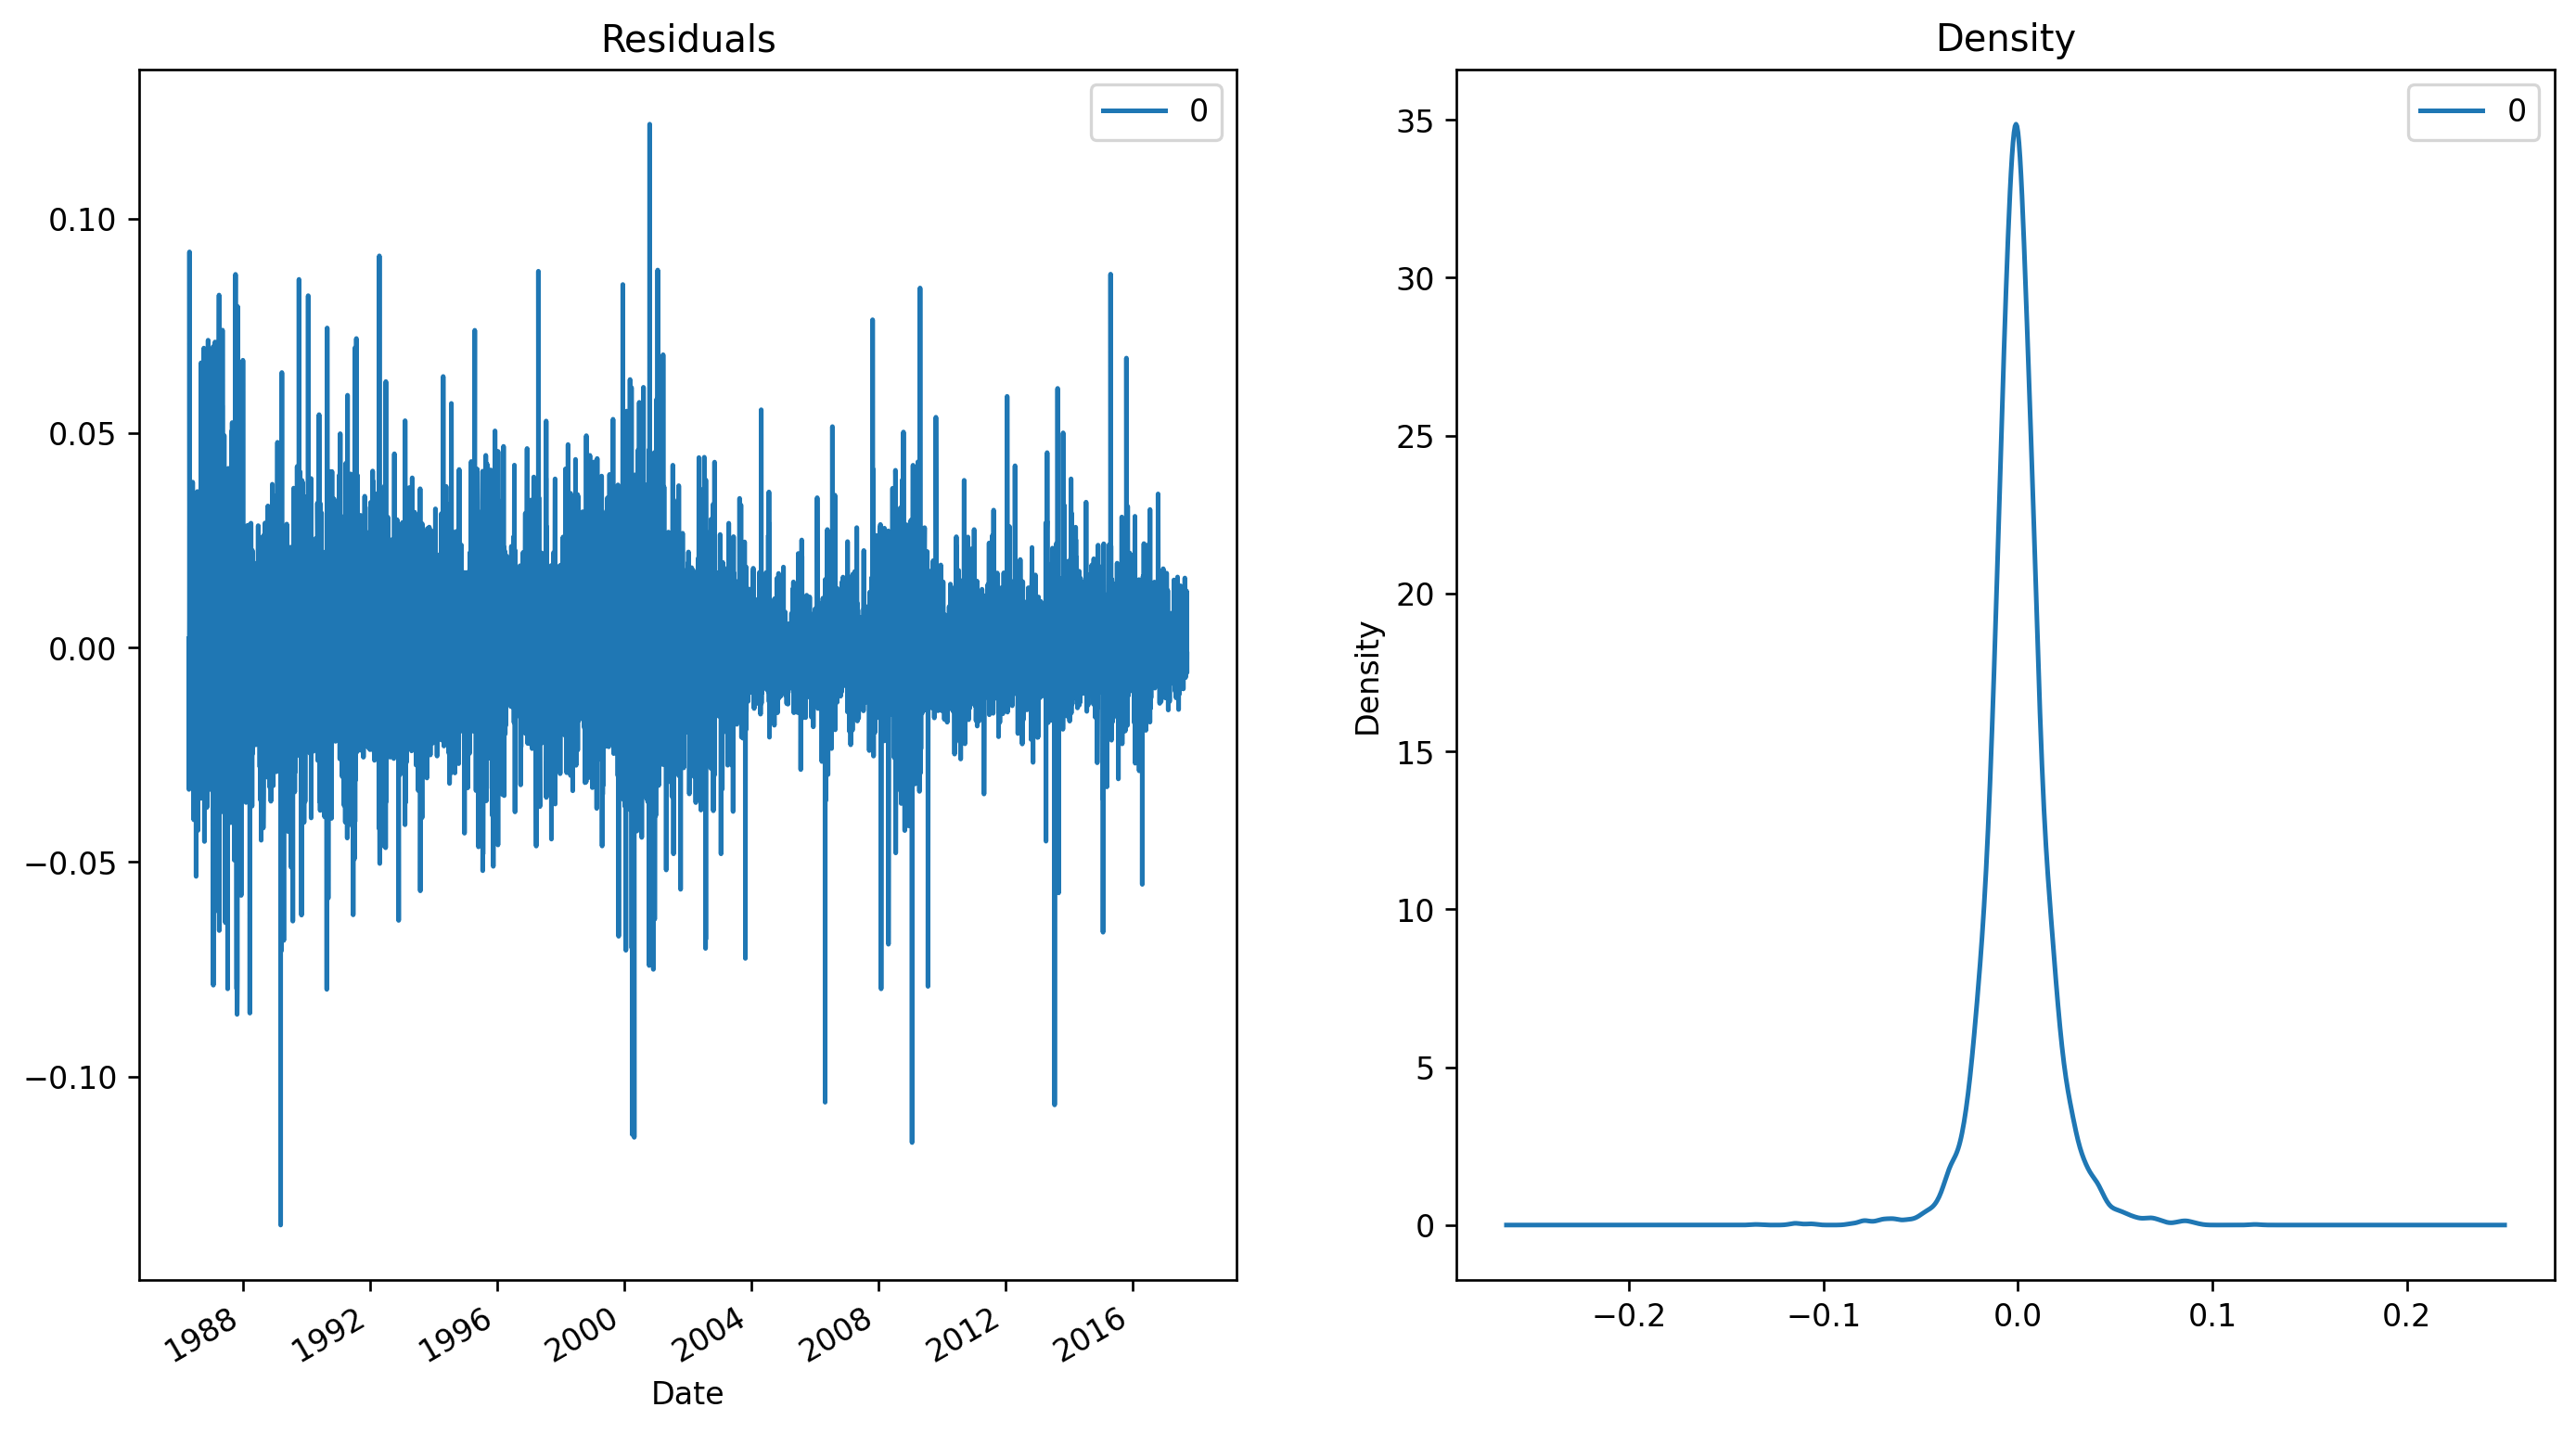

In [38]:

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
print ( "\n Constant  mean and variance observed")
plt.show()

### Comparision ARIMA :  Actual Vs Fitted 

<Figure size 600x480 with 0 Axes>

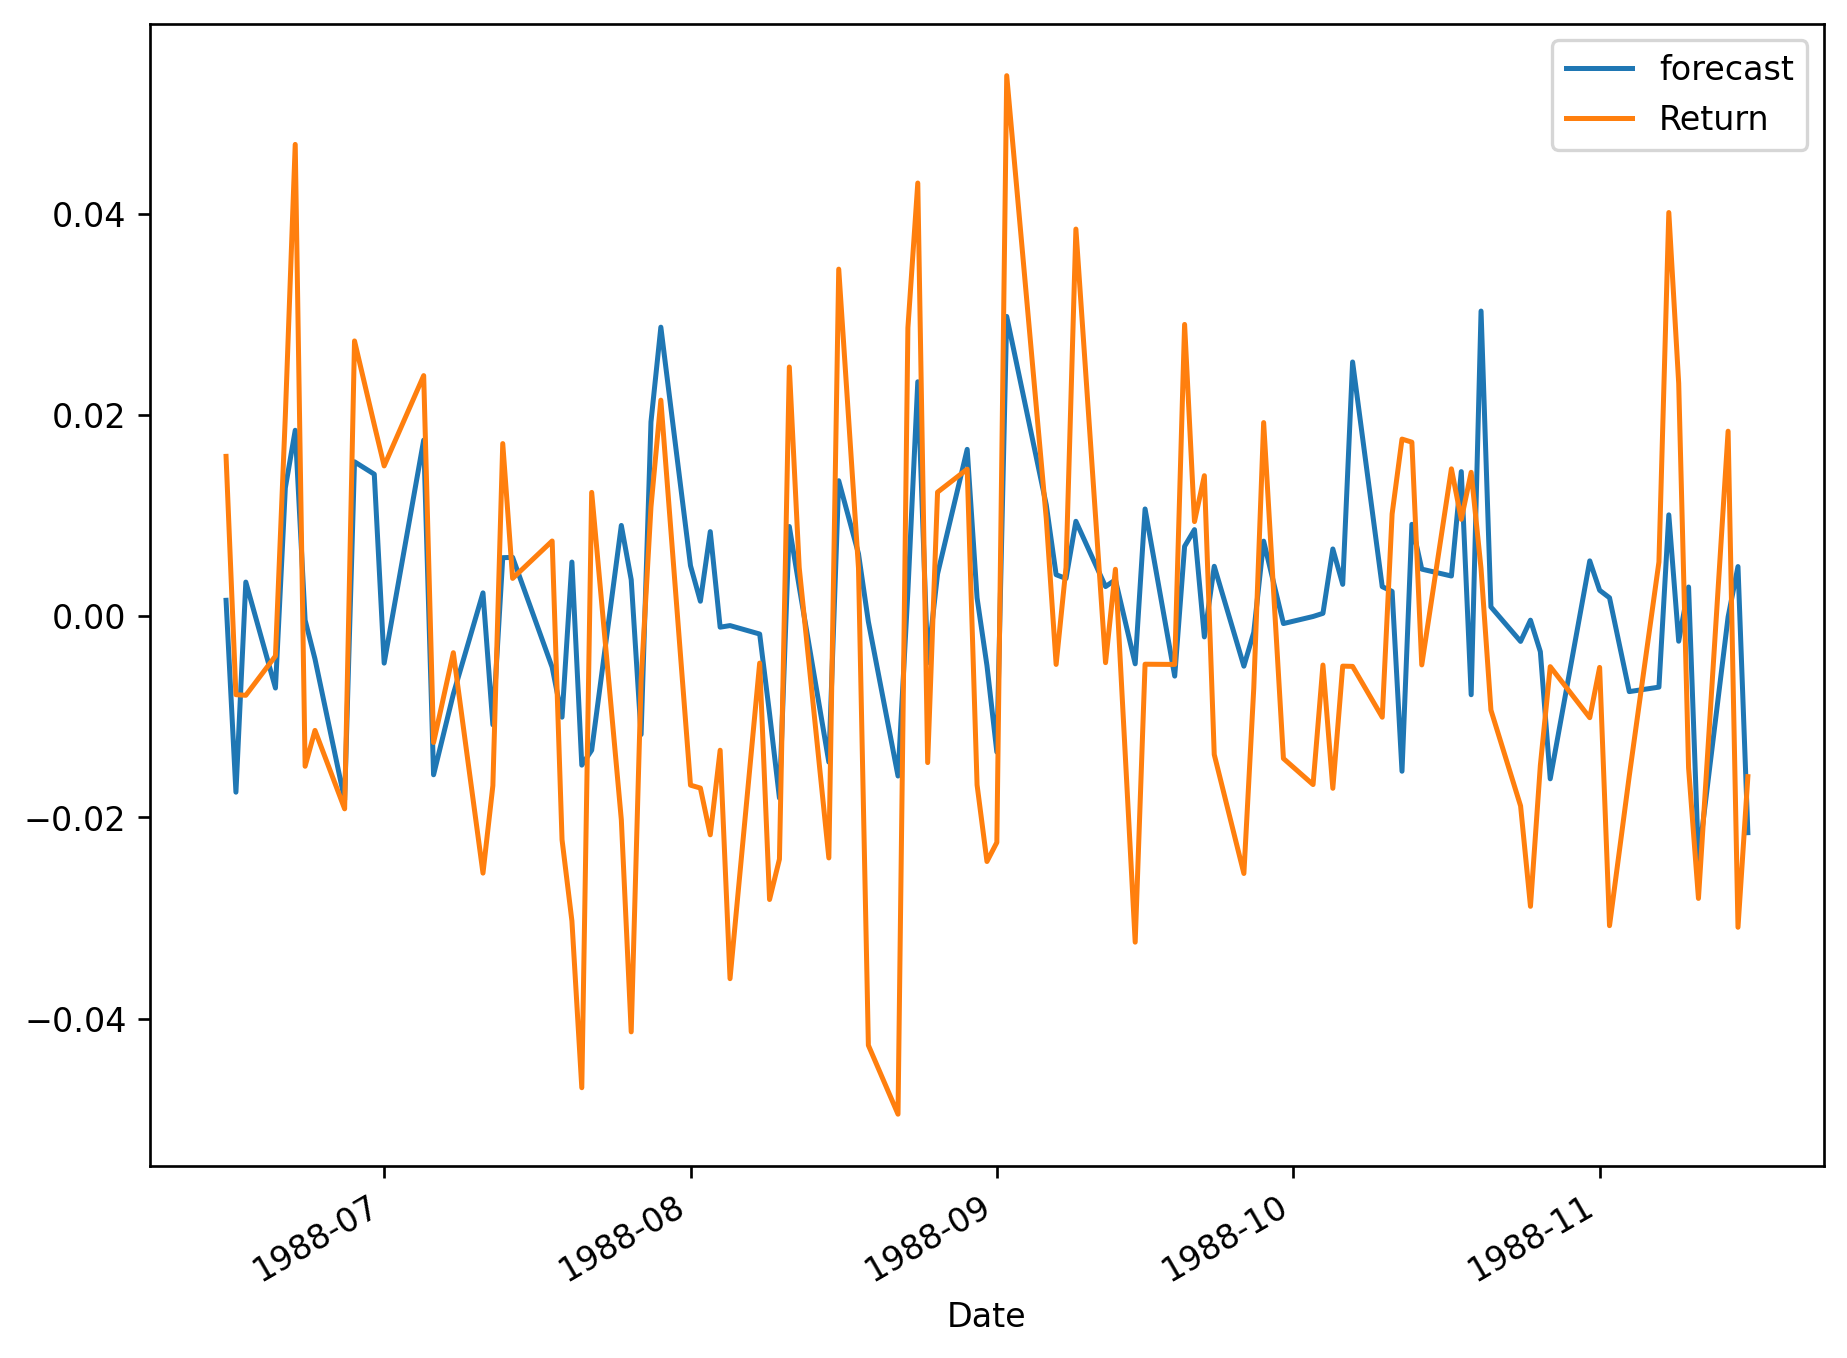

In [39]:
plt.figure(figsize=(5,4))
model_fit.plot_predict(dynamic=False, start=500, end=600)
plt.show()

## Forecasting 

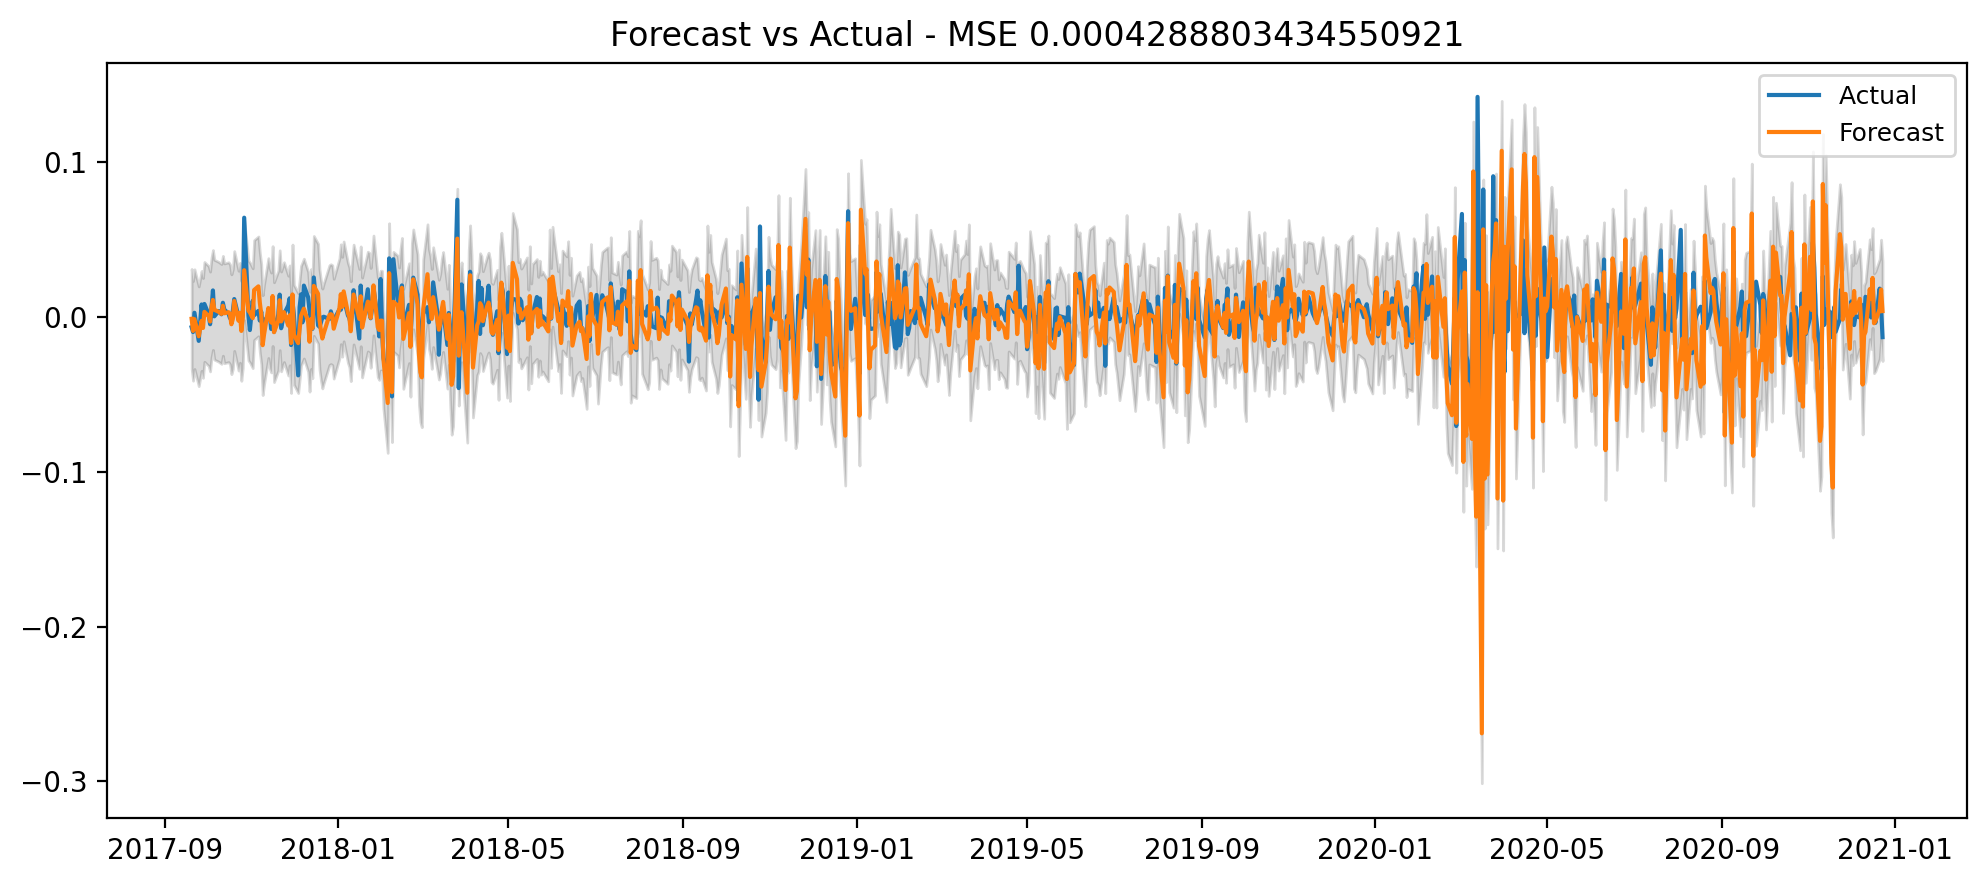

In [40]:
fc, se, conf = model_fit.forecast(valMinmax["Return"].shape[0], exog=valMinmax[exog], alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=valMinmax.index)
lower_series = pd.Series(conf[:, 0], index=valMinmax.index)
upper_series = pd.Series(conf[:, 1], index=valMinmax.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(valMinmax["Return"], label='Actual ')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actual - MSE {}'.format(mean_squared_error(valMinmax["Return"], fc)))
plt.legend(loc='upper right', fontsize=9)
plt.show()


### Accuracy metrics

In [41]:

from statsmodels.tsa.stattools import acf, pacf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-valMinmax["Return"])[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, valMinmax["Return"])

{'mape': 5.281918348988756,
 'me': -0.0030948517842444376,
 'mae': 0.013785490824133604,
 'mpe': -1.0430636625795668,
 'rmse': 0.02070942643954902,
 'acf1': 0.24866593982799914,
 'corr': 0.7159323332856339,
 'minmax': 1.523597030460161}

## **Part2 - DRL 

In [30]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-i1ehxora
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-i1ehxora
  Created wheel for finrl: filename=finrl-0.3.0-cp37-none-any.whl size=39054 sha256=ffec15dadf93ac473b99cfb1e6f4c6dfcb4c35ae808dc68e5ca2238ae30b7ce3
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5zzw53_/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
Successfully built finrl


In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# matplotlib.use('Agg')
import datetime
from pyfolio import timeseries
import pyfolio
from copy import deepcopy
%matplotlib inline

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [34]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

## Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [35]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [36]:
processed_full = pd.read_csv('/drive/My Drive/ml/processed_full.csv')

In [37]:
processed_full['date'] = pd.to_datetime(processed_full['date'])

In [38]:
processed_full

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,1986-03-13,MSFT,0.056108,0.064359,0.056108,0.061608,1031788800,3,0.000000,100.000000,66.666667,100.000000,0.000000
1,1986-03-14,MSFT,0.061608,0.064909,0.061608,0.063809,308160000,4,0.000049,100.000000,66.666667,100.000000,0.000000
2,1986-03-17,MSFT,0.063809,0.065459,0.063809,0.064909,133171200,0,0.000097,100.000000,78.380925,100.000000,0.000000
3,1986-03-18,MSFT,0.064909,0.065459,0.062708,0.063258,67766400,1,0.000057,65.398207,34.564039,4.970359,0.000000
4,1986-03-19,MSFT,0.063258,0.063809,0.061608,0.062158,47894400,2,-0.000010,52.802194,-29.926043,39.125450,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,2021-06-28,MSFT,266.190002,268.899994,265.910004,268.720001,19590000,0,4.550613,62.167133,143.169798,30.339899,0.563772
8896,2021-06-29,MSFT,268.869995,271.649994,267.980011,271.399994,19937800,1,4.926971,63.591597,153.856887,37.438367,0.257633
8897,2021-06-30,MSFT,270.690002,271.359985,269.600006,270.899994,21656500,2,5.125805,63.132824,144.637931,37.438367,0.037610
8898,2021-07-01,MSFT,269.609985,271.839996,269.600006,271.600006,16725300,3,5.279015,63.514050,138.559319,38.684591,0.005733


## Build Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of MSFT" or "Sell 10 shares of MSFT" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [39]:
train_len = int(len(processed_full) * 0.9)
test_len = int(len(processed_full) * 0.1)

train_start = processed_full.date[0]
train_end = processed_full.date[train_len]
test_start = processed_full.date[train_len]
test_end = processed_full.date[len(processed_full)-1] 

train = data_split(processed_full, train_start, train_end)
trade = data_split(processed_full, test_start, test_end)

print(len(train))
print(len(trade))

8010
889


In [40]:
test_start = '2019-12-31'
test_end = '2020-12-31'

train = data_split(processed_full, train_start, train_end)
trade = data_split(processed_full, test_start, test_end)

In [41]:
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST

In [42]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 7


In [43]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [44]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

In [45]:
agent = DRLAgent(env = env_train)

In [46]:
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [47]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_2
------------------------------------
| time/                 |          |
|    fps                | 315      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.45    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | -0.00724 |
|    std                | 1.03     |
|    value_loss         | 2e-05    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 316      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.47    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |
|

In [48]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [49]:
df_account_value

,date,account_value
0,2019-12-31,100000.000000
1,2020-01-02,100000.000000
2,2020-01-03,99787.185404
3,2020-01-06,99852.335741
4,2020-01-07,99544.499875
...,...,...
248,2020-12-23,149705.794667
249,2020-12-24,150808.823997
250,2020-12-28,152296.947369
251,2020-12-29,151795.850998


### A2C Backtesting Performance

In [50]:
baseline_df = processed_full

In [51]:
baseline_df = baseline_df[baseline_df['date']>='2019-12-31']

In [52]:
baseline_df = baseline_df[baseline_df['date']<='2020-12-31']

In [53]:
baseline_df

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
8520,2019-12-31,MSFT,154.413622,155.398591,154.098424,155.329636,18369400,1,2.609275,66.331324,100.366241,28.928631,0.009664
8521,2020-01-02,MSFT,156.393425,158.314112,155.950192,158.205765,22622100,3,2.741537,69.649469,144.290336,42.730974,1.773193
8522,2020-01-03,MSFT,155.940346,157.545836,155.684244,156.235825,21116200,4,2.656771,65.103352,111.932484,40.078369,1.325957
8523,2020-01-06,MSFT,154.719007,156.708649,154.157567,156.639694,20813700,0,2.592301,65.579835,91.130676,25.738723,0.001740
8524,2020-01-07,MSFT,156.925308,157.270038,154.955370,155.211456,21634100,1,2.398314,62.459887,84.984934,28.611335,0.843160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8769,2020-12-24,MSFT,220.402277,222.582213,220.183287,221.726166,10550600,3,2.301275,56.053163,184.120134,21.350679,0.047807
8770,2020-12-28,MSFT,223.418329,224.991069,221.994910,223.925995,17933500,0,2.598028,57.377321,201.561988,27.978144,0.086630
8771,2020-12-29,MSFT,225.269796,226.135792,222.552348,223.119720,17403200,1,2.736602,56.729230,176.773917,30.934569,0.038087
8772,2020-12-30,MSFT,224.194758,224.592928,220.452045,220.661072,20272300,2,2.617854,54.777434,121.110263,21.178537,0.215172


In [54]:
df = deepcopy(df_account_value)
test_returns = get_daily_return(df, value_col_name="account_value")
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

Start date,2019-12-31
End date,2020-12-30
Total months,12
,Backtest
Annual return,49.865%
Cumulative returns,50.106%
Annual volatility,33.912%
Sharpe ratio,1.37
Calmar ratio,2.72
Stability,0.82
Max drawdown,-18.339%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.34,2020-02-10,2020-03-23,2020-04-14,47
1,13.16,2020-09-02,2020-11-02,NaT,NaN
2,5.93,2020-08-03,2020-08-11,2020-08-25,17
3,5.63,2020-04-17,2020-04-21,2020-04-30,10
4,5.36,2020-06-10,2020-06-11,2020-06-22,9


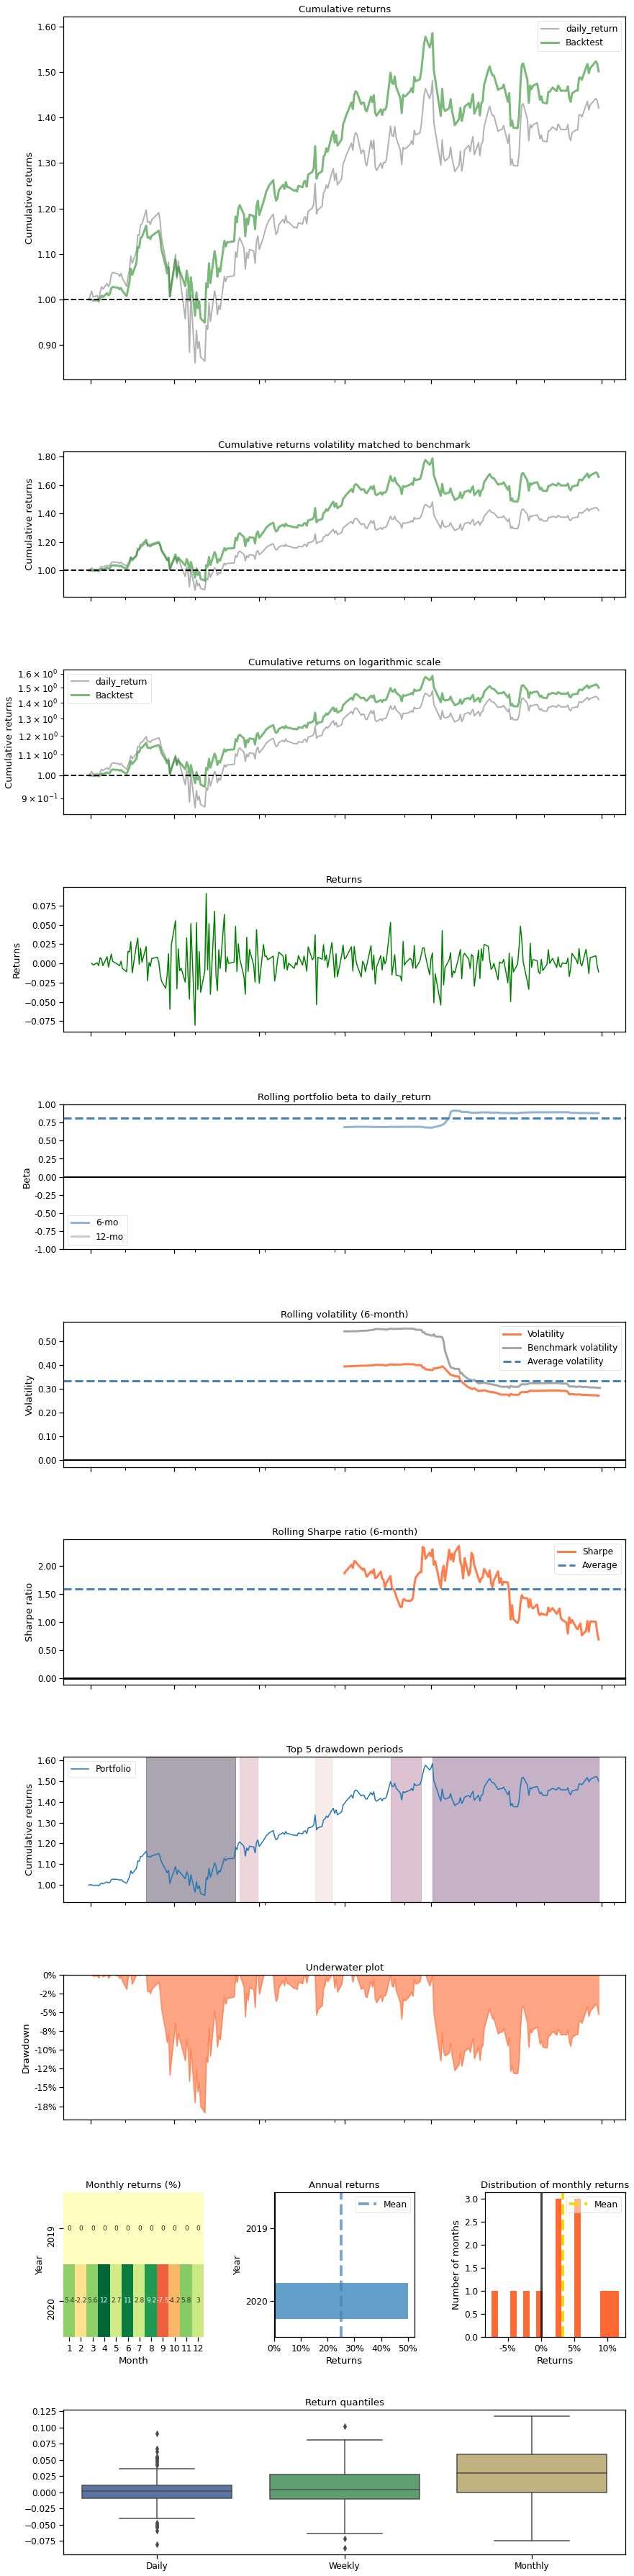

In [55]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(
        returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

In [64]:
pnl = (get_daily_return(df, value_col_name="account_value") + 1).cumprod() - 1

In [65]:
pnl

date
2019-12-31 00:00:00+00:00         NaN
2020-01-02 00:00:00+00:00    0.000000
2020-01-03 00:00:00+00:00   -0.002128
2020-01-06 00:00:00+00:00   -0.001477
2020-01-07 00:00:00+00:00   -0.004555
                               ...   
2020-12-23 00:00:00+00:00    0.497058
2020-12-24 00:00:00+00:00    0.508088
2020-12-28 00:00:00+00:00    0.522969
2020-12-29 00:00:00+00:00    0.517959
2020-12-30 00:00:00+00:00    0.501059
Name: daily_return, Length: 253, dtype: float64

### GRAPH Comparision Cumulative PNL : ARIMA vs DRL

PNL  - ARIMA
            ARIMA_Cumulative_PNL
Date                            
2020-01-02              0.025306
2020-01-03              0.013927
2020-01-06              0.021112
2020-01-07              0.004177
2020-01-08              0.013080


PNL-  DRL 
            DRL_Cumulative_PNL
Date                          
2020-01-02            0.002721
2020-01-03           -0.001366
2020-01-06           -0.000309
2020-01-07           -0.006181
2020-01-08            0.005355


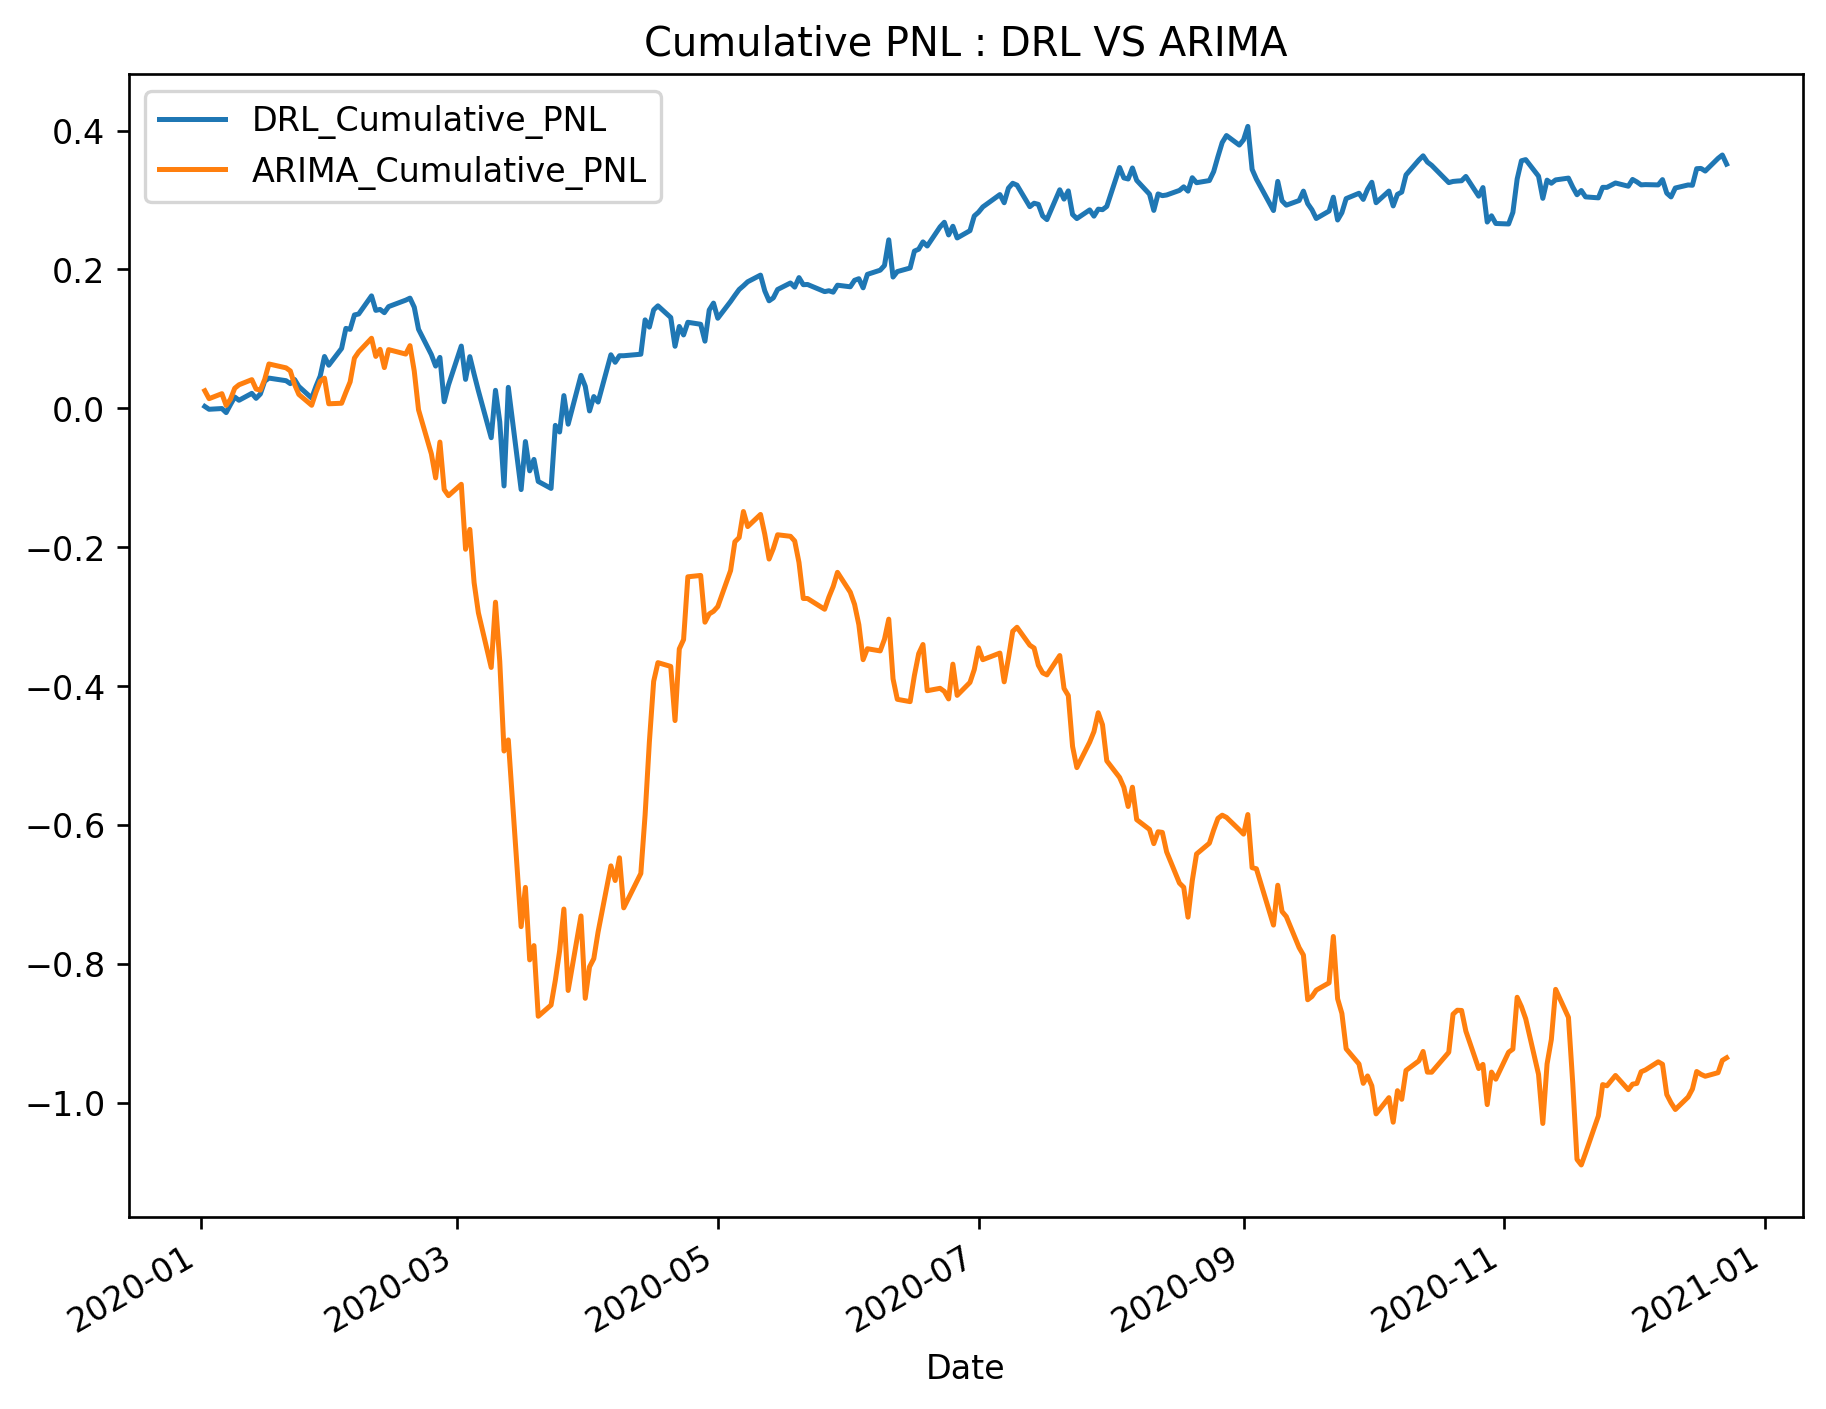

In [44]:
## ARIMA PNL 
pnl_df =  pd.DataFrame(fc, index = valMinmax[["Return"]].index)
pnl_df.columns = ["ARIMA_Forecast"]
pnl_df = pd.concat([pnl_df,valMinmax[["Return"]]], ignore_index = False ,axis =1)
pnl_df.columns = ["ARIMA_Forecast","Actual_MSFT_return"]
pnl_df = pnl_df[pnl_df.index.year == 2020]
pnl_df["ARIMA_Cumulative_PNL"] =  pnl_df["ARIMA_Forecast"].cumsum()
print("PNL  - ARIMA")
print(pnl_df[["ARIMA_Cumulative_PNL"]].head(5))

### DRL PNL
PNL_DRL_df = pd.read_csv("pnl.csv")
PNL_DRL_df.reset_index().drop("index",axis =1)
PNL_DRL_df.date = pd.to_datetime(PNL_DRL_df.date.apply(lambda x : str(x).replace("00:00:00+00:00","")))
PNL_DRL_df.columns = ["Date","DRL_Cumulative_PNL"]
PNL_DRL_df = PNL_DRL_df.set_index("Date")
print("\n\nPNL-  DRL ")
print(PNL_DRL_df.head(5))

## extract csv 
df_PNL.to_csv("PNL_ARIMA_DRL.csv")
##

df_PNL = pd.concat([PNL_DRL_df,pnl_df[["ARIMA_Cumulative_PNL"]]],ignore_index = False, join = "inner",axis =1)
df_PNL.plot(title = "Cumulative PNL : DRL VS ARIMA")
plt.show()

## Conclusion 

* We observed PNL of DRL model is much greater in comparision of ARIMA model
* Machine Learning models can deliver returns without much human supervision 
* Application of the machine learning approach requires less manual criteria selection processes, which reduces human biases, while still being able to deliver significant returns. 

- ML Performance Enhancement  
* Greater training datasets could improve ML model performance  